In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import *
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [20]:
EPOCHS = 500
EPOCH_PATIENCE = 25
BATCH_SIZE = 64
LR = 0.1
NUM_CLASSES = 102

In [21]:
# Define the PyTorch model with BatchNorm2d
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm for the first conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm for the second conv layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm for the third conv layer
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)  # BatchNorm for the fourth conv layer
        
        # Dense layers
        self.fc1 = nn.Linear(256 * 12 * 12, 1024)  # Adjust input features to match your final conv layer output
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, NUM_CLASSES)  # Adjust output features to match your number of classes

    def forward(self, x):
        # Convolutional layers with activation, batch normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten the tensor for dense layers
        x = x.view(-1, 256 * 12 * 12)  # Adjust to match your final conv layer output
        
        # Dense layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        
        return x


In [22]:
def update_transform(epoch):
    new_transform = copy.deepcopy(train_transform_1)
    
    # Basic transformations
    if epoch > 10:
        new_transform.transforms.insert(0, RandomHorizontalFlip(p=0.5))
    if epoch > 15:
        new_transform.transforms.insert(0, RandomVerticalFlip(p=0.5))
        new_transform.transforms.insert(1, RandomRotation(degrees=15))  # Adjusted rotation
    if epoch > 20:
        new_transform.transforms[1] = RandomRotation(degrees=45)  # Gradual increase in rotation
    # Intermediate transformations
    if epoch > 30:
        new_transform.transforms.insert(4, RandomAffine(degrees=0, translate=(0.1, 0.1)))  # Gradual affine
    if epoch > 40:
        new_transform.transforms.insert(5, RandomPerspective(distortion_scale=0.2, p=0.2))  # Gradual perspective
    
    return new_transform

In [23]:
train_transform_1 = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

train_transform_2 = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    RandomRotation(degrees=90),
    RandomHorizontalFlip(p=0.5),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(hue=.05, saturation=.05),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

train_transform_3 = Compose([
    Resize((256, 256)),
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0)),
    RandomRotation(degrees=45),
    RandomVerticalFlip(p=0.8),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

train_transform_4 = transforms.Compose([
    RandomVerticalFlip(),
    RandomHorizontalFlip(),
    RandomRotation(20),
    RandomResizedCrop(224, scale=(0.7, 1.0)),
    RandomAdjustSharpness(0.3),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
])

val_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])

test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.4330, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175]),
])

In [24]:
train_data_1 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_1)
train_data_2 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_2)
train_data_3 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_3)
train_data_4 = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=train_transform_4)
train_data = train_data_4
val_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='val', download=True, transform=val_transform)
test_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='test', download=True, transform=test_transform)

In [25]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # Wrap the model with nn.DataParallel
    model = nn.DataParallel(model)
    model = model.cuda()

In [27]:
import time

start_time = time.time()

# Create Variables To Tracks Things
epochs = EPOCHS
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Early Stopping Parameters
patience = EPOCH_PATIENCE  # How many epochs to wait after val loss has stopped improving
min_val_loss = float('inf')  # Initialize to infinity
stale_epochs = 0  # Counter for epochs without improvement

# For Loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Update the train_loader with the new transformations
    # current_transform = update_transform(i)  # Get the updated transform for the current epoch
    # train_data.transform = current_transform  # Update the transform in the dataset
    # train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)  # Recreate the DataLoader with the updated dataset

    # Train
    for b, (X_train, y_train) in enumerate(train_loader, 1):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
        loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

        predicted = torch.max(y_pred.data, 1)[
            1]  # add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
        trn_corr += batch_corr  # keep track as we go along in training.

        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

            # Print out some results
        if b % BATCH_SIZE == 0:
            print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        val_loss = 0
        for b, (X_test, y_test) in enumerate(val_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            val_loss += criterion(y_val, y_test).item()  # Sum up the loss from each batch

    avg_val_loss = val_loss / len(val_loader)  # Calculate the average loss
    loss = criterion(y_val, y_test)

    test_losses.append(loss)
    test_correct.append(tst_corr)

    # Early Stopping Check
    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        stale_epochs = 0  # Reset the stale epochs counter
        best_model_state = model.state_dict()
    else:
        stale_epochs += 1  # Increment the stale epochs counter
        if stale_epochs >= patience:
            print(f'Stopping early at epoch {i} due to overfitting.')
            model.load_state_dict(best_model_state)
            break  # Break out of the loop

    print(f'Epoch: {i} Validation Loss: {avg_val_loss}')

current_time = time.time()
total = current_time - start_time
print(f'Training Took: {total / 60} minutes!')


Epoch: 0 Validation Loss: 18.942291140556335
Epoch: 1 Validation Loss: 32.97223445773125
Epoch: 2 Validation Loss: 9.472519636154175
Epoch: 3 Validation Loss: 30.008048743009567
Epoch: 4 Validation Loss: 51.66604268550873
Epoch: 5 Validation Loss: 4.628094732761383
Epoch: 6 Validation Loss: 4.639168292284012
Epoch: 7 Validation Loss: 4.627704203128815
Epoch: 8 Validation Loss: 4.627316415309906
Epoch: 9 Validation Loss: 4.62769216299057
Epoch: 10 Validation Loss: 4.627982944250107
Epoch: 11 Validation Loss: 152.30712869763374
Epoch: 12 Validation Loss: 106.88968876004219
Epoch: 13 Validation Loss: 37.73823654651642
Epoch: 14 Validation Loss: 4.627915799617767
Epoch: 15 Validation Loss: 214.14508378505707
Epoch: 16 Validation Loss: 4.627610772848129
Epoch: 17 Validation Loss: 9.93821308016777
Epoch: 18 Validation Loss: 5.021489709615707
Epoch: 19 Validation Loss: 37.522901475429535
Epoch: 20 Validation Loss: 4.628069519996643
Epoch: 21 Validation Loss: 4.628395050764084
Epoch: 22 Valida

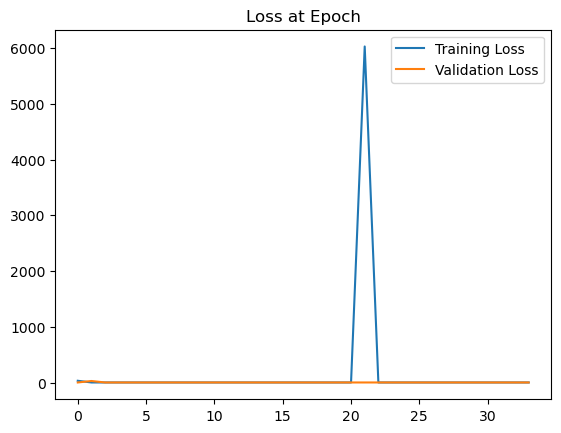

In [28]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
test_losses = [tl.cpu().detach().numpy() for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

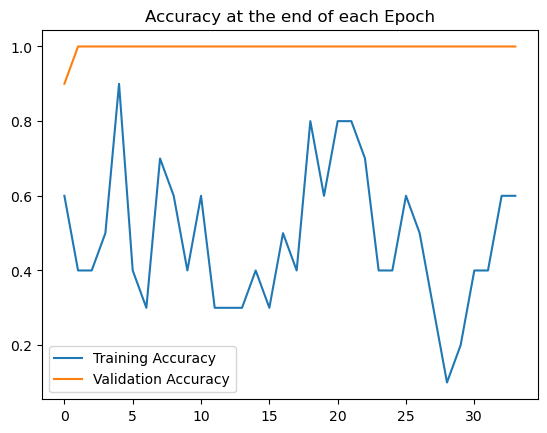

In [31]:
plt.plot([t.cpu()/10 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/10 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [30]:
from torch.utils.data import DataLoader

test_load_everything = DataLoader(test_data, batch_size=512, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for X_test, y_test in test_load_everything:
        X_test, y_test = X_test.to('mps'), y_test.to('mps')
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

Accuracy of the model on the test set: 0.42%
